In [53]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from data_preprocessing import get_data

#### Load Data

In [54]:
X_train, y_train, X_test, y_test, y_scaler, train_loader, test_loader = get_data(
            timestep = 10,
            batch_size = 64,
            y_name = 'Closing price',
            train_size = 6627,
            path = "Data/SSE000001.csv")
y_test = y_scaler.inverse_transform(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([6618, 10, 8]) torch.Size([6618, 1]) torch.Size([490, 10, 8]) (490, 1)


#### Search for GPU

In [55]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    print ("GPU device not found.")

mps


In [56]:
class BILSTM(nn.Module):
    def __init__(self, input_size = 8, lstm_num_layers = 1, lstm_hidden_size = 64, lstm_dropout = 0.2, fc1_output_size = 16):
        super(BILSTM, self).__init__()
        self.input_size = input_size
        self.lstm_num_layers = lstm_num_layers
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_dropout = lstm_dropout
        self.fc1_output_size = fc1_output_size

        self.lstm = nn.LSTM(input_size = self.input_size, 
                             hidden_size = self.lstm_hidden_size,
                             num_layers = self.lstm_num_layers,
                             batch_first = True,
                             bidirectional = True)
        
        # self.lstm2 = nn.LSTM(input_size = self.lstm_hidden_size * 2, 
        #                      hidden_size = self.lstm_hidden_size,
        #                      num_layers = self.lstm_num_layers,
        #                      batch_first = True,
        #                      bidirectional = True)

        # self.dropout = nn.Dropout(p = self.lstm_dropout)
        self.fc1 = nn.Linear(self.lstm_hidden_size * 2, self.fc1_output_size)
        self.fc2 = nn.Linear(self.fc1_output_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm_num_layers * 2, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.lstm_num_layers * 2, x.size(0), self.lstm_hidden_size).to(device)

        # x = F.relu(x)

        h_lstm, _ = self.lstm(x, (h0, c0))
        # h_lstm = self.dropout(h_lstm)

        h_fc1 = self.fc1(h_lstm)
        h_fc1 = F.relu(h_fc1)

        h_fc2 = self.fc2(h_fc1)
        output = h_fc2[:, -1, :]

        return output

#### Define the model

In [72]:
input_size = 8
lstm_num_layers = 1
lstm_hidden_size = 64
lstm_dropout = 0.2
fc1_output_size = 16
learning_rate = 0.0001
num_epoch = 20

model = BILSTM(input_size=input_size, 
               lstm_num_layers=lstm_num_layers, 
               lstm_hidden_size=lstm_hidden_size, 
               fc1_output_size=fc1_output_size).to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.L1Loss() # Mean Absolute Error

#### Train

In [73]:
model.train(True)

for epoch in range(num_epoch):
    for batch_index, batch in enumerate(train_loader):
        X, y_true = batch[0].to(device), batch[1].to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            print('Epoch {0}, Batch {1}, Loss: {2:.6f}'.format(epoch, batch_index, loss.item()))
            display.clear_output(wait=True)

model.train(False)

BILSTM(
  (lstm): LSTM(8, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

#### Save the model

In [77]:
path = "models/BILSTM_{0}Epoch_{1}Lr_{2}Layer_{3}Size.pt".format(num_epoch, learning_rate, lstm_num_layers, lstm_hidden_size)
torch.save(model.state_dict(), path)

#### Load the model

In [ ]:
# model = BILSTM()
# model.load_state_dict(torch.load(path))
# model.eval()

#### Evaluate

In [75]:
with torch.no_grad():
    y_train_pred = model(X_train.to(device)).to('cpu')
    y_test_pred = model(X_test.to(device)).to('cpu')

y_test_pred = y_scaler.inverse_transform(y_test_pred)

train_mse = mean_squared_error(y_train_pred, y_train, squared=False)
test_mse = mean_squared_error(y_test_pred, y_test, squared=False)

train_mae = mean_absolute_error(y_train_pred, y_train)
test_mae = mean_absolute_error(y_test_pred, y_test)

train_r2 = r2_score(y_train_pred, y_train)
test_r2 = r2_score(y_test_pred, y_test)

print("Train RMSE: {0:.6f}; Test RMSE {1:.6f}\n".format(train_mse, test_mse))
print("Train  MAE: {0:.6f}; Test  MAE {1:.6f}\n".format(train_mae, test_mae))
print("Train  R^2: {0:.6f}; Test  R^2 {1:.6f}\n".format(train_r2, test_r2))

Train RMSE: 0.040643; Test RMSE 38.340305

Train  MAE: 0.023417; Test  MAE 26.461379

Train  R^2: 0.998348; Test  R^2 0.967867



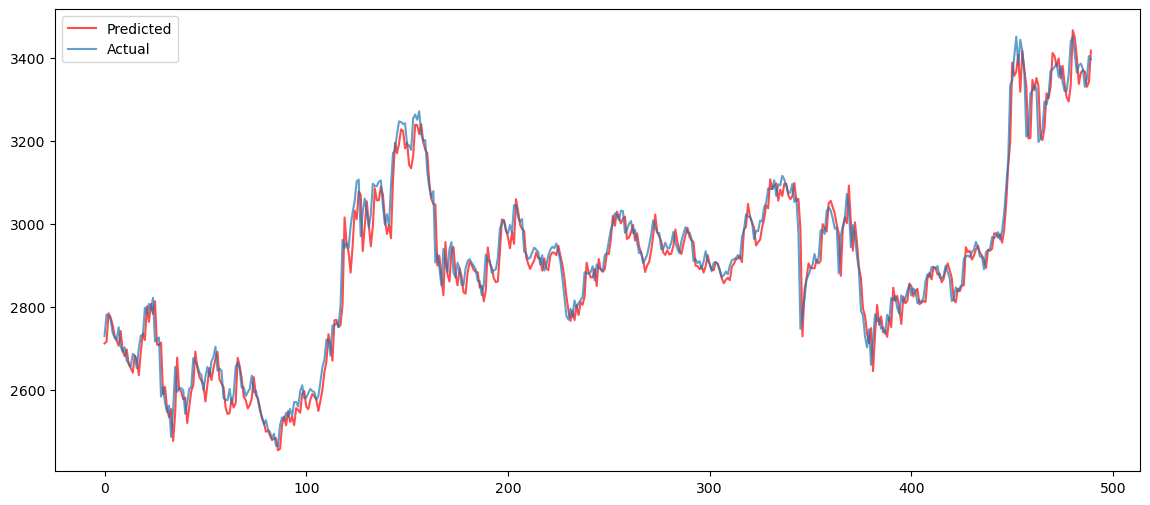

In [63]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_pred, label='Predicted', alpha=0.7, color='red')
plt.plot(y_test, label='Actual', alpha=0.7)
plt.legend()
plt.show()